In [1]:
import cv2
import numpy as np

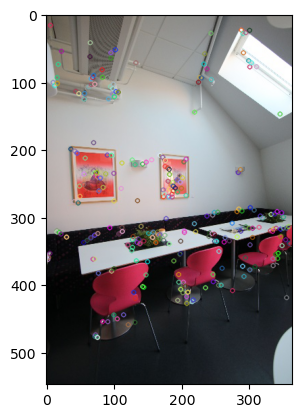

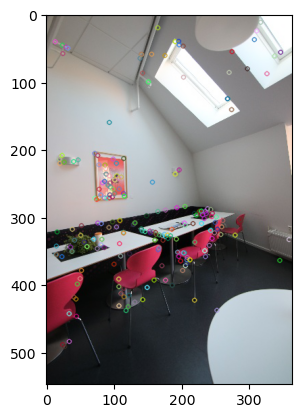

(<matplotlib.image.AxesImage at 0x287c4933488>, None)

In [2]:
import cv2
import matplotlib.pyplot as plt
images = ['img1_ratio01.jpg', 'img2_ratio01.jpg', 'img3_ratio01.jpg', 'img4_ratio01.jpg', 'img5_ratio01.jpg', 'img6_ratio01.jpg']
im = []
for img in images:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im.append(img)

# Load the images
img1 = cv2.imread('img1_ratio01.jpg')
img2 = cv2.imread('img2_ratio01.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Detect key points and extract descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Draw key points on the images
img1_with_keypoints = cv2.drawKeypoints(img1, kp1, None)
img2_with_keypoints = cv2.drawKeypoints(img2, kp2, None)

# Display the images with keypoints
plt.imshow(img1_with_keypoints), plt.show()
plt.imshow(img2_with_keypoints), plt.show()

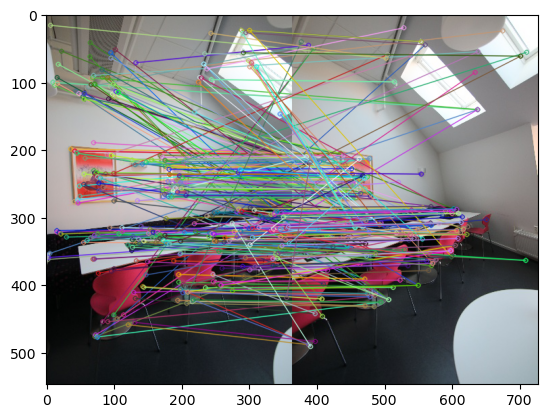

(<matplotlib.image.AxesImage at 0x287c482afc8>, None)

In [3]:
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Match descriptors
matches = bf.knnMatch(des1,des2,k=2)
all_matches = [m for m, n in matches]

img_matches1 = cv2.drawMatches(img1, kp1, img2, kp2, all_matches, None, flags=2)

plt.imshow(img_matches1), plt.show()

In [4]:
"""
# Define FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict()   # empty dictionary

# Create a FLANN matcher object
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Perform the matching between the SIFT descriptors
matches = flann.knnMatch(des1, des2, k=2)
"""

'\n# Define FLANN parameters\nFLANN_INDEX_KDTREE = 0\nindex_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)\nsearch_params = dict()   # empty dictionary\n\n# Create a FLANN matcher object\nflann = cv2.FlannBasedMatcher(index_params, search_params)\n\n# Perform the matching between the SIFT descriptors\nmatches = flann.knnMatch(des1, des2, k=2)\n'

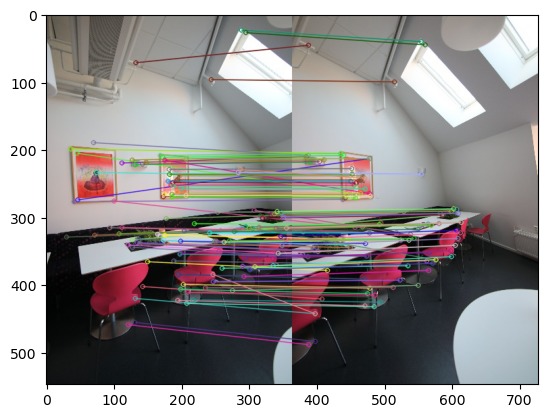

(<matplotlib.image.AxesImage at 0x287c48b3208>, None)

In [5]:
# Lowe's ratio test
ratio = 0.8
good_matches = []

for m, n in matches:
    if m.distance < ratio * n.distance:
        good_matches.append(m)

# Draw the matches satisfying Lowe's criterion
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
plt.imshow(img_matches), plt.show()

In [6]:
points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute Homography
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC,5.0)
# RANSAC returns a mask that indicates the inlier and outlier points

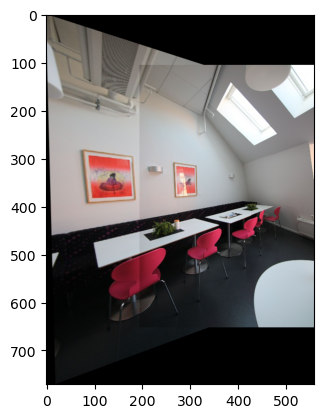

In [7]:
def warpImages(img1, img2, H):
        rows1, cols1 = img1.shape[:2]
        rows2, cols2 = img2.shape[:2]

        list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
        temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

        # When we have established a homography we need to warp perspective
        # Change field of view
        list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

        list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

        [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
        [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
        translation_dist = [-x_min,-y_min]
  
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

        output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
        output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

        return output_img

result = warpImages(img2, img1, H)
        
plt.imshow(result)

In [8]:
def stitchImages(img1, img2):

    # Create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # Detect key points and extract descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Draw key points on the images
    img1_with_keypoints = cv2.drawKeypoints(img1, kp1, None)
    img2_with_keypoints = cv2.drawKeypoints(img2, kp2, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # BF is more accurate and runtime was not a problem in this exercise 

    # Match descriptors
    matches = bf.knnMatch(des1,des2,k=2)
    all_matches = [m for m, n in matches]

    img_matches1 = cv2.drawMatches(img1, kp1, img2, kp2, all_matches, None, flags=2)
    # Lowe's ratio test
    ratio = 0.8
    good_matches = []

    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    # Draw the matches satisfying Lowe's criterion
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
    points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute Homography
    H, _ = cv2.findHomography(points1, points2, cv2.RANSAC,5.0)

    result = warpImages(img2, img1, H)

    plt.imshow(result)

    return result


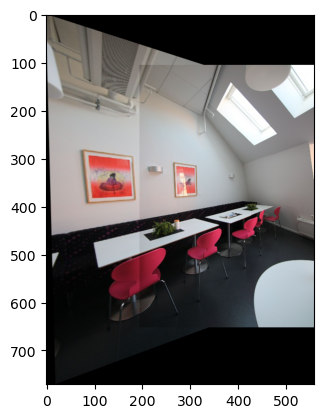

In [9]:
temp01 = stitchImages(im[0], im[1])

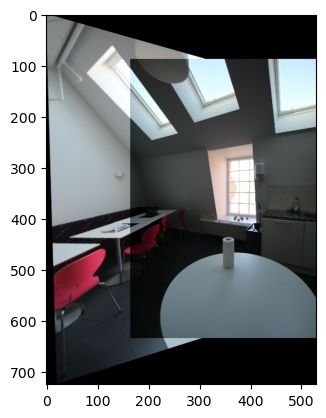

In [11]:
temp23 = stitchImages(im[2], im[3])

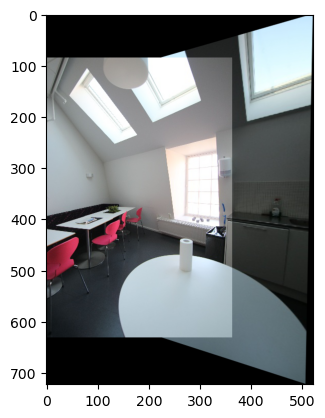

In [12]:
temp32 = stitchImages(im[3], im[2])

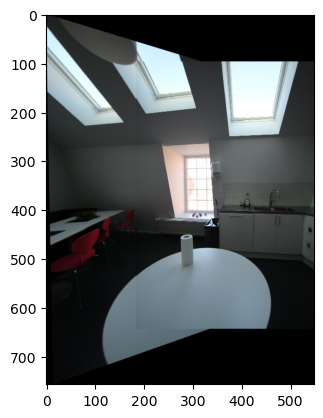

In [13]:
temp34 = stitchImages(im[3], im[4])

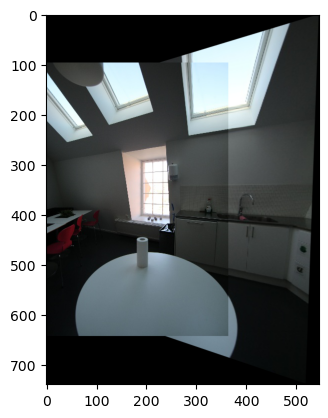

In [14]:
temp43 = stitchImages(im[4], im[3])

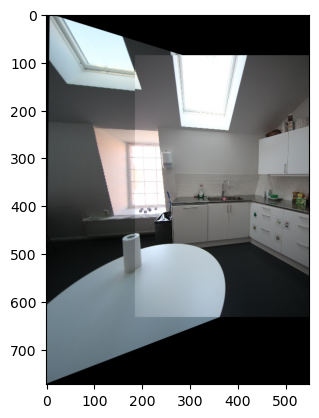

In [15]:
temp45 = stitchImages(im[4], im[5])

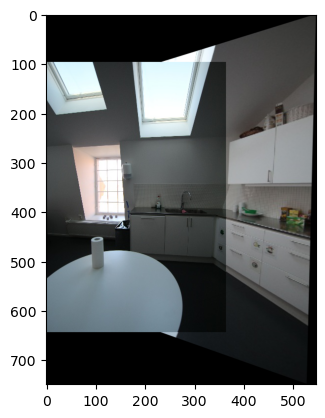

In [16]:
temp54 = stitchImages(im[5], im[4])

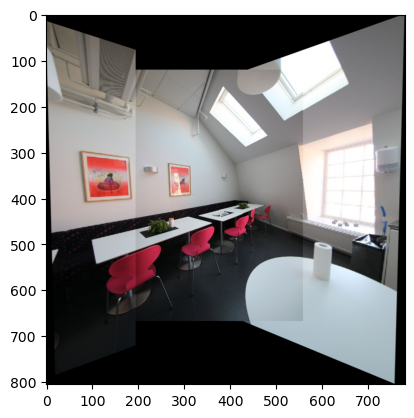

In [20]:
temp0_21 = stitchImages(im[0], temp21)

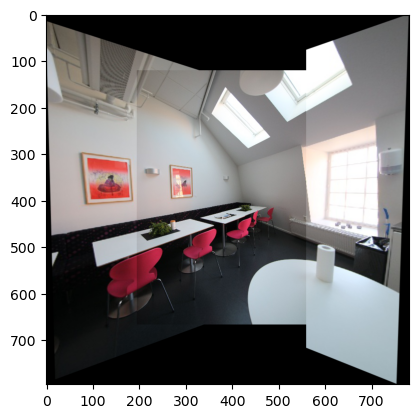

In [21]:
temp2_01 = stitchImages(im[2], temp01)

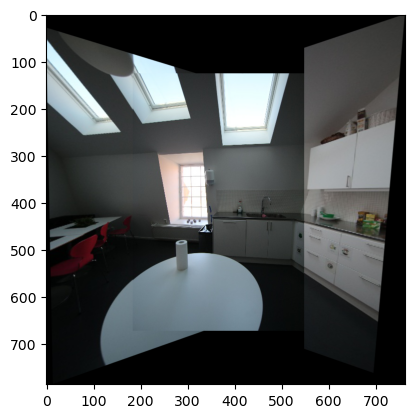

In [40]:
temp5_34 = stitchImages(im[5], temp34)

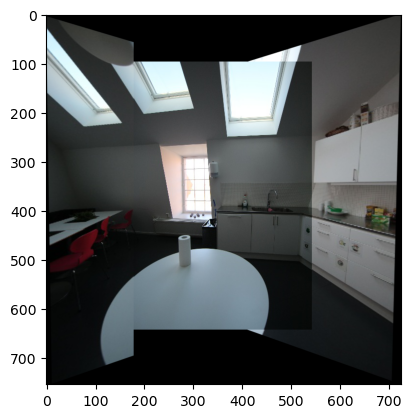

In [48]:
temp3_54 = stitchImages(im[3], temp54)

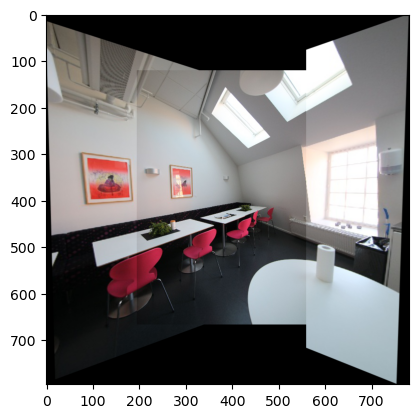

In [51]:
temp2_01 = stitchImages(im[2], temp01)

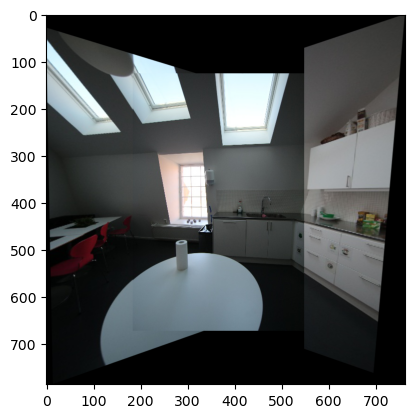

In [63]:
temp5_34 = stitchImages(im[5], temp34)

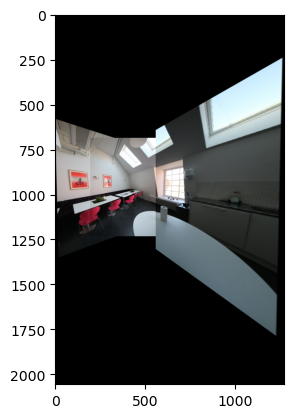

In [76]:
temp = stitchImages(temp23, temp01 )

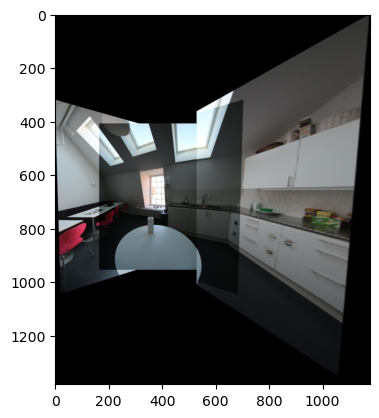

In [82]:
temp = stitchImages(temp54,  temp23)

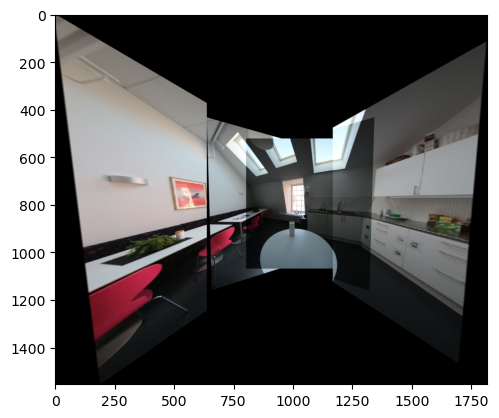

In [93]:
a = stitchImages(im[1], temp)